# Analysis the results

In [26]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os, sys
import numpy as np

import torch
from torch.utils.data import DataLoader, DistributedSampler, random_split, TensorDataset
from torch import nn
import matplotlib.pyplot as plt

In [27]:
def read_one_results(path):
    with open(path, "r") as outfile:
        data = json.load(outfile)
    return data

def write_one_results(path, json_data):
    with open(path, "w") as outfile:
        json.dump(json_data, outfile)
        
def display_data_hist(loss):
    plt.hist(loss, bins=50, label='Box-based')
    plt.title('Loss Distribution')
    plt.xlabel('Loss')
    plt.ylabel('Probability Density')
    locs, _ = plt.yticks()
    plt.yticks(locs,np.round(locs/loss.shape[0],3))
    plt.legend()
    plt.show()
    
def np_read(file):
    with open(file, "rb") as outfile:
        data = np.load(outfile)
    return data
def np_write(data, file):
    with open(file, "wb") as outfile:
        np.save(outfile, data)

In [34]:
val_path = "./data/5_scale_31/val/feature_pre_data/annotation.npy"
val_losses = np_read(val_path)
train_path = "./data/5_scale_31/train/feature_pre_data/annotation.npy"
train_losses = np_read(train_path)

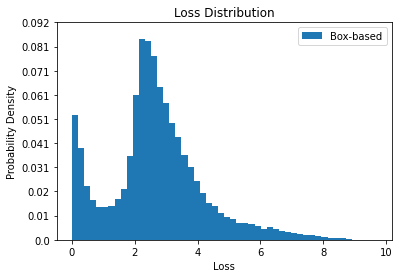

In [35]:
display_data_hist(val_losses)

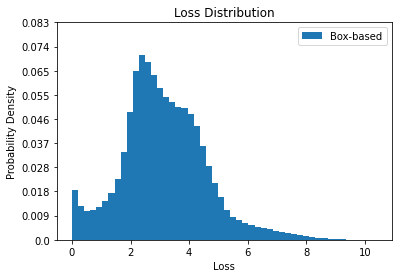

In [36]:
display_data_hist(train_losses)

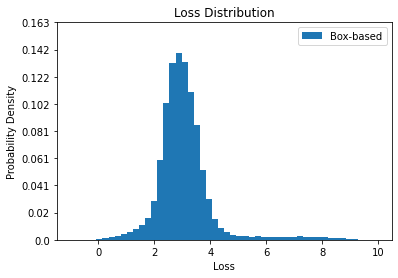

In [33]:
val_path = "/workspace/ViT-pytorch/output/ViT-feature-train-60000_losses.json"
feature_vit_losses = np.array(read_one_results(val_path)["losses"])
display_data_hist(feature_vit_losses)

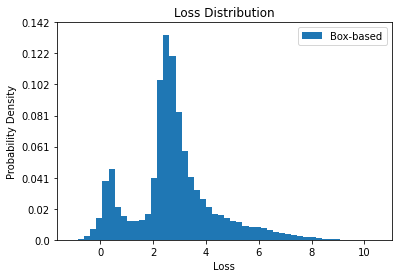

In [24]:
val_path = "/workspace/ViT-pytorch/output/ViT-feature-train-with-test_losses.json"
feature_vit_losses = np.array(read_one_results(val_path)["losses"])
display_data_hist(feature_vit_losses)

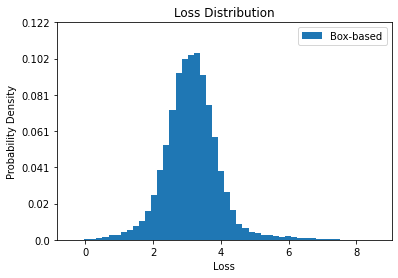

In [25]:
val_path = "./results/loss_analysis/box_based_ridge_regression_feature.npy"
feature_vit_losses = np_read(val_path)
display_data_hist(feature_vit_losses)

In [3]:
results_path = "./results/loss_analysis/"
i_ase_results = read_one_results(results_path + "image_based_ASE.json")
i_rr_results = read_one_results(results_path + "image_based_redge_regression.json")
b_rr_results = read_one_results(results_path + "box_based_redge_regression.json")
image_true_loss = np.array(i_rr_results['true loss'])
box_true_loss = np.array(b_rr_results['true loss'])
i_ase_loss = np.array(i_ase_results['estimated loss'])
i_rr_loss = np.array(i_rr_results['estimated loss'])
b_rr_loss = np.array(b_rr_results['estimated loss'])

In [5]:
vit_path = "/workspace/ViT-pytorch/output/"
estimated_loss_path = vit_path + "ViT-train-with-test_retrain_losses.json"
b_vit_test_loss = np.array(read_one_results(estimated_loss_path)['losses'])
b_vit_loss = np.array(read_one_results(vit_path + "ViT-train-20000_losses.json")['losses'])

In [6]:
def transf_to_percetage(values):
    return values / values.sum()
image_true_loss_p = transf_to_percetage(image_true_loss)
box_true_loss_p = transf_to_percetage(box_true_loss)
i_ase_loss_p = transf_to_percetage(i_ase_loss)
i_rr_loss_p = transf_to_percetage(i_rr_loss)
b_rr_loss_p = transf_to_percetage(b_rr_loss)
b_vit_loss_p = transf_to_percetage(b_vit_loss)

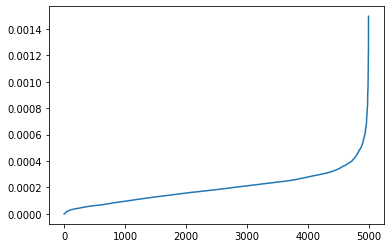

In [24]:
image_true_loss_p_sort = np.sort(image_true_loss_p)
plt.plot(np.arange(image_true_loss_p_sort.shape[0]), image_true_loss_p_sort)
plt.show()

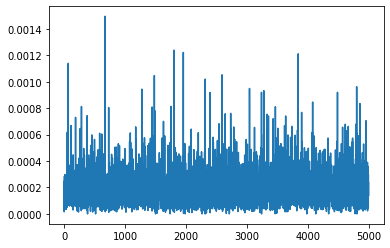

In [27]:
plt.plot(np.arange(image_true_loss_p.shape[0]), image_true_loss_p)
plt.show()

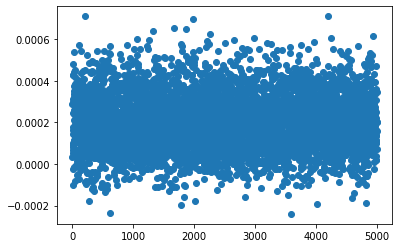

In [27]:
plt.scatter(np.arange(image_true_loss_p.shape[0]), i_rr_loss_p)
plt.show()

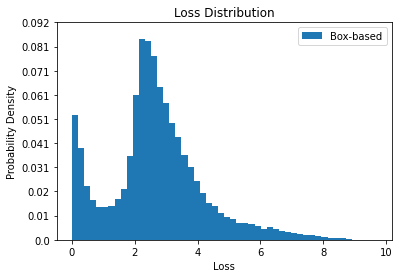

In [8]:
display_data_hist(box_true_loss)

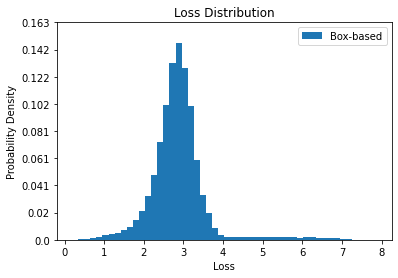

In [9]:
display_data_hist(b_vit_loss)

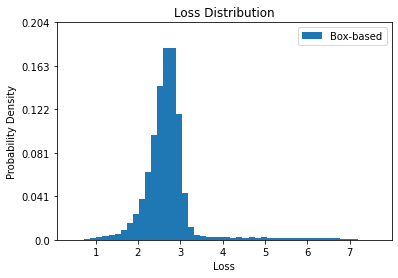

In [11]:
display_data_hist(b_vit_test_loss)

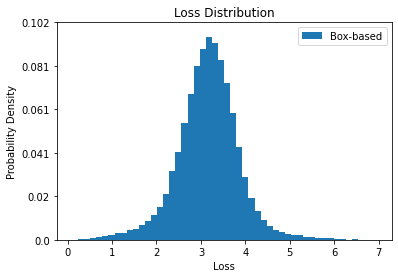

In [10]:
display_data_hist(b_rr_loss)

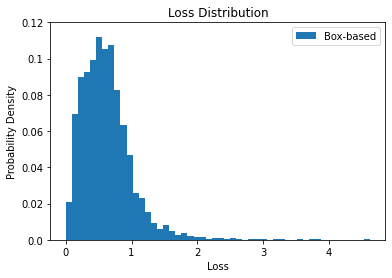

In [30]:
plt.hist(image_true_loss, bins=50, label='Box-based')
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/image_true_loss.shape[0],3))
plt.legend()
plt.show()

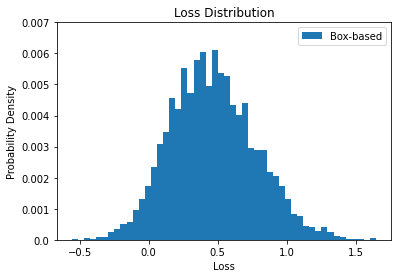

In [31]:
plt.hist(i_rr_loss, bins=50, label='Box-based')
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/b_rr_loss.shape[0],3))
plt.legend()
plt.show()

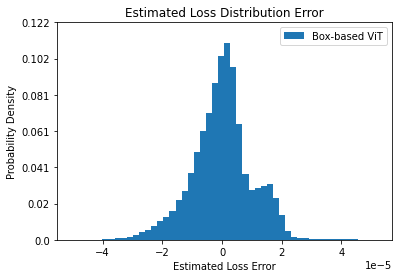

In [11]:
b_vit_loss_error = b_vit_loss_p - box_true_loss_p
plt.hist(b_vit_loss_error, bins=50, label='Box-based ViT')
plt.title('Estimated Loss Distribution Error')
plt.xlabel('Estimated Loss Error')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/b_vit_loss_error.shape[0],3))
plt.legend()
plt.show()

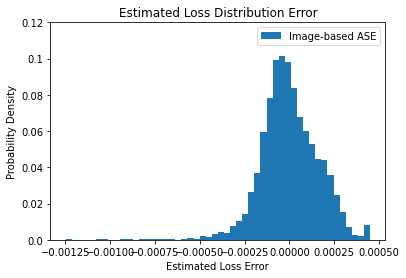

In [8]:
i_ase_loss_error = i_ase_loss_p - image_true_loss_p
i_rr_loss_error = i_rr_loss_p - image_true_loss_p
b_rr_loss_error = b_rr_loss_p - box_true_loss_p
plt.hist(i_ase_loss_error, bins=50, label='Image-based ASE')
# plt.hist(i_rr_loss_error, bins=50, label='Image-based RR')
# plt.hist(b_rr_loss_error, bins=50, label='Box-based RR')
plt.title('Estimated Loss Distribution Error')
plt.xlabel('Estimated Loss Error')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/i_ase_loss_error.shape[0],3))
plt.legend()
plt.show()

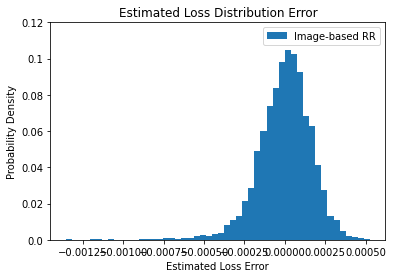

In [9]:
plt.hist(i_rr_loss_error, bins=50, label='Image-based RR')
plt.title('Estimated Loss Distribution Error')
plt.xlabel('Estimated Loss Error')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/i_ase_loss_error.shape[0],3))
plt.legend()
plt.show()

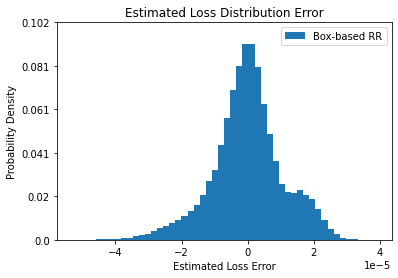

In [10]:
plt.hist(b_rr_loss_error, bins=50, label='Box-based RR')
plt.title('Estimated Loss Distribution Error')
plt.xlabel('Estimated Loss Error')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/b_rr_loss_error.shape[0],3))
plt.legend()
plt.show()

In [16]:
np.absolute(b_rr_loss_error).sum()

0.39624252760459194

In [17]:
np.absolute(i_rr_loss_error).sum()

0.6204263944291746

In [18]:
np.absolute(i_ase_loss_error).sum()

0.6099535208952915

In [20]:
np.absolute(b_rr_loss_error).mean()

8.06534893046046e-06

In [21]:
np.absolute(i_rr_loss_error).mean()

0.0001240852788858349

In [22]:
np.absolute(i_ase_loss_error).mean()

0.0001219907041790583